In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#Read the collected data
df = pd.read_csv('CardataCombinedWithKorimalli.csv')

#Lets change names to english
df.columns = ['Index','Car type', 'Price', 'Id', 'Yearly Check', 'Sub type','Limited benefit','Model', 'Mileage','Engine','Seller','Owner amount','Updated','License plate number', 'Location', 'Power','Delivery Cost','Transmission','Manufacturer','Full Benefit','Drivetrain','Year']

#Drop if ID is empty
df = df.dropna(subset=['Index'])

#Lets drop some unnecessary columns
df=df.drop(columns=['Index', 'Id', 'Yearly Check','Owner amount','Updated','License plate number','Delivery Cost','Limited benefit','Full Benefit'])
#Lets drop the rows with NULL values
df = df.dropna(how='any',axis=0) 
df.head()

#Lets clean data, where Engine is Electric or only Bensiini or Diesel, without Engine Size information. 
#And lets give average engine size to them so we can still have them with us, but engine size wont distort the results.
df.Engine[df.Engine == 'Sähkö'] = '20 , Sähkö'
df.Engine[df.Engine == 'Diesel'] = '20 , Diesel'
df.Engine[df.Engine == 'Bensiini'] = '20 , Bensiini'
df.Engine[df.Engine == 'Hybridi'] = '20 , Hybridi'


"""
E85/bensiini                      75      16     75      16  
Hybridi                         1163      18   1163      18  
Hybridi (bensiini/kaasu)          13       5     13       7  
Hybridi (bensiini/sähkö)         373      16    373      18  
Hybridi (diesel/sähkö)  """


#Lets change Saab models back to text, because excel changes them to dates.
df.Model[df.Model == '09-May'] = '9-5'
df.Model[df.Model == '09-Mar'] = '9-3'

#Lets separate Engine type and size to different columns.
new = df["Engine"].str.split(",", n = 1, expand = True) 
df["Engine Size"]= new[0] 
df['Engine Size'] = df['Engine Size'].map(lambda x: str(x)[:-2])
df["Fuel type"]= new[1]
df.drop(columns =["Engine"], inplace = True) 
df['Engine Size']=df['Engine Size'].astype('float')

#Muutetaan erikoiset hybridityypit -> hybridi ja E85/bensiini -> Bensiini
df["Fuel type"] = df["Fuel type"].replace([' Hybridi (bensiini/kaasu)',' Hybridi (bensiini/sähkö)',' Hybridi (diesel/sähkö)'],' Hybridi')
df["Fuel type"] = df["Fuel type"].replace([' E85/bensiini'],' Bensiini')


#Lets create area from Location and frop City information
new = df["Location"].str.split(",", n = 1, expand = True) 
df["Area"]= new[1]
df.drop(columns =["Location"], inplace = True) 

#Lets drop cars that location is outside Finland, because the price may vary because of different tax policy
df = df[~df.Area.str.endswith("Suomen ulkopuolella")]

#Change all different company names to just Company
def change_names(x):
    if x == 'Private seller':
        return 'Private seller'
    else:
        return 'Company'
df['Seller'] = df['Seller'].apply(change_names)

#Lets see if there is null and drop those rows
df = df[pd.notnull(df['Fuel type'])]
total = df.isnull().sum().sort_values(ascending=False)

#Lets define the target attribute
target = 'Price'

#Lets change Price and Mileage from float to int
df['Price']=df['Price'].astype('int')
df['Mileage']=df['Mileage'].astype('int')
df['Power']=df['Power'].astype('int')
df['Year']=df['Year'].astype('int')



#df.head(10)
df.describe()
df.dtypes
df['Sub type'].unique()

array(['viistoperä', 'farmari', 'tila-auto', 'pakettiauto', 'maastoauto',
       'avoauto', 'porrasperä', 'coupé', 'kevyt kuorma-auto', 'minibussi',
       'jatko-ohjaamo', 'avolava', 'kilpa-ajoneuvo'], dtype=object)

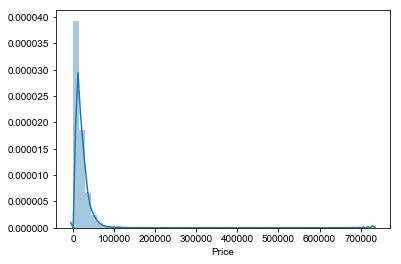

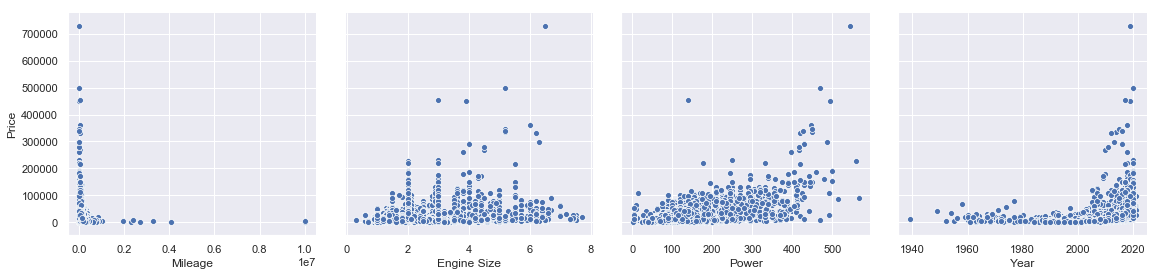

<Figure size 2880x2880 with 0 Axes>

<Figure size 2880x2880 with 0 Axes>

In [48]:
df['Price'].describe()

#histogram
sns.distplot(df['Price']);

#Scatterplot
sns.set()
#sns.pairplot(df)
sns.pairplot(df,x_vars=["Mileage","Engine Size","Power","Year"],y_vars="Price",size=4)


plt.show();

plt.figure(figsize=(40,40)) 


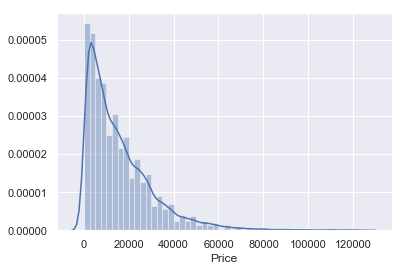

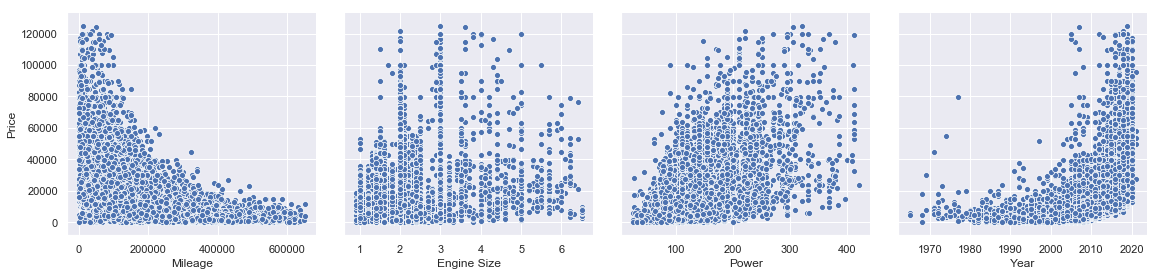

,Price,Mileage,Power,Year,Engine Size
count,28153.000000,28153.000000,28153.000000,28153.000000,28153.000000
mean,15880.963059,173043.921181,113.579086,2010.394452,1.990388
std,15054.924080,115006.209163,46.069696,6.771870,0.672225
min,100.000000,650.000000,24.000000,1965.000000,0.900000
25%,4900.000000,81000.000000,82.000000,2006.000000,1.600000
50%,11800.000000,160000.000000,104.000000,2011.000000,2.000000
75%,22690.000000,249000.000000,135.000000,2016.000000,2.100000
max,124900.000000,650000.000000,420.000000,2021.000000,6.500000


In [49]:
#Lets drop all cars that have mileage of over 650 000 km or under 650 km
df = df[~(df[['Mileage']] > 650000).all(axis=1)]
df = df[~(df[['Mileage']] < 650).all(axis=1)]

#Lets drop all cars that year model is older than 1965
df = df[~(df[['Year']] < 1965).all(axis=1)]

#Lets drop all cars that price is over 125000 € or under 100 €
df = df[~(df[['Price']] > 125000).all(axis=1)]
df = df[~(df[['Price']] < 100).all(axis=1)]

#Lets drop all cars that engine size is over 6.5 or under 0.9 Litres
df = df[~(df[['Engine Size']] > 6.5).all(axis=1)]
df = df[~(df[['Engine Size']] < 0.9).all(axis=1)]


df = df[~(df[['Power']] < 20).all(axis=1)]
df = df[~(df[['Power']] > 420).all(axis=1)]


sns.distplot(df['Price']);

#Scatterplot
sns.set()
sns.pairplot(df,x_vars=["Mileage","Engine Size","Power","Year"],y_vars="Price",size=4)
plt.show();

df.describe()

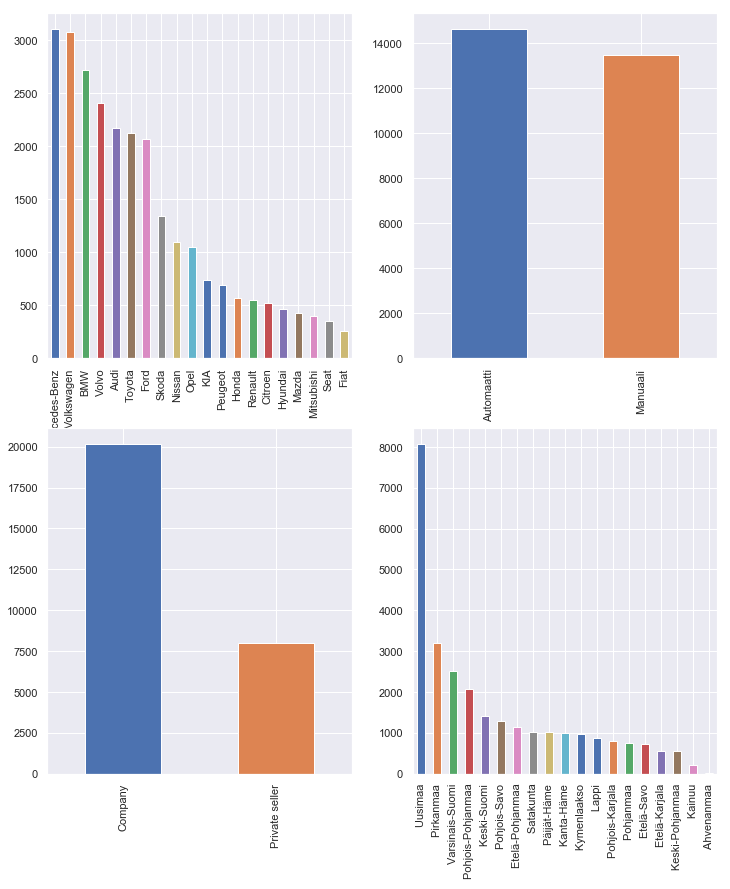

In [50]:
#Lets see how many numerical and categorical features is there
numerical_feats = df.dtypes[df.dtypes != "object"].index
categorical_feats = df.dtypes[df.dtypes == "object"].index

fig, axarr = plt.subplots(2, 2, figsize=(12, 14))

df['Manufacturer'].value_counts().head(20).plot.bar(
    ax=axarr[0][0])

df['Seller'].value_counts().sort_index().plot.bar(
    ax=axarr[1][0])

df['Transmission'].value_counts().sort_index().plot.bar(
    ax=axarr[0][1])

df['Area'].value_counts().head(20).plot.bar(
    ax=axarr[1][1])

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Lets decide features that we want to use
features = ['Sub type','Model', 'Mileage','Engine Size','Fuel type','Power','Transmission','Manufacturer','Drivetrain','Year']

#Testing labelEncoder
"""
df["Model"] =LabelEncoder().fit_transform(df["Model"])
df["Seller"] =LabelEncoder().fit_transform(df["Seller"])
df["Transmission"] =LabelEncoder().fit_transform(df["Transmission"])
df["Manufacturer"] =LabelEncoder().fit_transform(df["Manufacturer"])
df["Drivetrain"] =LabelEncoder().fit_transform(df["Drivetrain"])
df["Fuel type"] =LabelEncoder().fit_transform(df["Fuel type"])"""


#Defines price as a component what we want to know and then features which we want to use to calculate the price
y = df.Price
X = pd.get_dummies(df[features])
#X = df[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [52]:
from sklearn.ensemble import RandomForestRegressor
import joblib

#Random forest regressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

filename = 'rfr64bitWithSubtype.sav'
joblib.dump(rf, filename)
print('Random forest accurary:',rf.score(X_test,y_test))

Random forest accurary: 0.953565367062972


In [59]:
### This will ask you to enter your car details.
manufacturer = input('Manufacturer: ')
model = input('Model: ')   
year = input('Year: ')
mileage = int(input('Mileage tkm: '))
mileage = mileage * 1000
power = int(input('Power kW: '))

fuel_type = int(input('Fuel type: 1=Bensiini, 2=Diesel, 3=Hybridi, 4=Sähkö, 5=Kaasu: '))
if fuel_type == 1:
    fuel_type = "Bensiini"
elif fuel_type == 2:
    fuel_type = "Diesel"
elif fuel_type == 3:
    fuel_type = "Hybridi"
elif fuel_type == 4:
    fuel_type = "Sähkö"
elif fuel_type == 5:
    fuel_type = "Kaasu"
fuel_type = ' ' + fuel_type

#If fuel type is electric it will not ask engine size, because there is none. 
#We will use the mean size, which is 2.0 just like we did in cleaning phase.
if fuel_type == ' ' + 'Sähkö':
    engine_size = 2.0
else:
    engine_size = input('Engine size: ')

#power = int(input('Power: '))
    
drivetrain = int(input('Drivetrain: 1=Etuveto, 2=Takaveto, 3=Neliveto: '))
if drivetrain == 1:
    drivetrain = "Etuveto"
elif drivetrain == 2:
    drivetrain = "Takaveto"
elif drivetrain == 3:
    drivetrain = "Neliveto"
    
transmission = int(input('Transmission: 1=Manuaali, 2=Automaatti: '))
if transmission == 1:
    transmission = "Manuaali"
elif transmission == 2:
    transmission = "Automaatti"

sub_type = int(input('Sub type: 1=Hatchpack, 2=Farmari, 3=Porrasperä, 4=Coupe: '))
if sub_type == 1:
    sub_type = "viistoperä"
elif sub_type == 2:
    sub_type = "farmari"
elif sub_type == 3:
    sub_type = "porrasperä"
elif sub_type == 4:
    sub_type = "coupé" 
    
#Deletes all the files from dataframe, but leaves columns just like they were
odt=(X_test[:1])
for col in odt.columns:
    odt[col].values[:] = 0
    
#Enter values of the car that price you want to predict.
odtmodel = 'Model_' + model
odttransimission = 'Transmission_' + transmission
odtmanufacturer = 'Manufacturer_' + manufacturer
odtdrivetrain = 'Drivetrain_' + drivetrain
odtfueltype = 'Fuel type_' + fuel_type
odtsubtype = 'Sub type_' + sub_type
 
odt.loc[:, 'Year'] = year
odt.loc[:, 'Power'] = power
odt.loc[:, 'Mileage'] = mileage
odt.loc[:, 'Engine Size'] = engine_size
odt.loc[:,  odtsubtype] = 1
odt.loc[:,  odtmodel] = 1
odt.loc[:,  odttransimission] = 1
odt.loc[:,  odtmanufacturer] = 1
odt.loc[:,  odtdrivetrain] = 1
odt.loc[:,  odtfueltype] = 1

try:
    price = int((rf.predict(odt)))
    print("\n")
    print('Car price is (Without scaling)',price)
except:
    print('Maker/Model unknown to database')
    

Manufacturer: Volvo
Model: V70
Year: 2014
Mileage tkm: 94
Power kW: 132
Fuel type: 1=Bensiini, 2=Diesel, 3=Hybridi, 4=Sähkö, 5=Kaasu: 5
Engine size: 2.0
Drivetrain: 1=Etuveto, 2=Takaveto, 3=Neliveto: 1
Transmission: 1=Manuaali, 2=Automaatti: 2
Sub type: 1=Hatchpack, 2=Farmari, 3=Porrasperä, 4=Coupe: 2


Car price is (Without scaling) 24022
